In [7]:
# %%
"""
Import libraries, model, and datasets
"""
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

src_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(src_dir, '..')) + '/src'  # Adjust the path as needed
print(src_dir)

sys.path.append(src_dir)
# sys.path.append(f'{src_dir}/src')

import MLC_utils as utils
import MI.model_backtrack as backtrack

src_dir = Path(src_dir)
model_path = src_dir / 'out_models' / 'net-HookedBIMLSmall.pt'
dataset_path = src_dir / 'test_data_long' 
single_trial_path = dataset_path /'single_trial'
null_dataset_path = dataset_path/ 'null_dataset.pt'

net, dataset = utils.load_net_and_dataset(model_path=model_path, 
                                              dataset_path=dataset_path, 
                                              null_dataset_path=null_dataset_path)

/Users/laptopd/Documents/Compositionality/MLC-extension/src
* Setting all random seeds to  0 *
Loading model: /Users/laptopd/Documents/Compositionality/MLC-extension/src/out_models/net-HookedBIMLSmall.pt on cpu

Transformer specs:
 nparams= 930953
 nlayers_encoder= 2
 nlayers_decoder= 2
 nhead= 8
 hidden_size= 128
 dim_feedforward= 512
 act_feedforward= gelu
 dropout= 0.1
 



/Users/laptopd/Documents/Compositionality/MLC-extension/src/MI/hooked_transformer.py:298: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


/Users/laptopd/opt/anaconda3/envs/MI/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


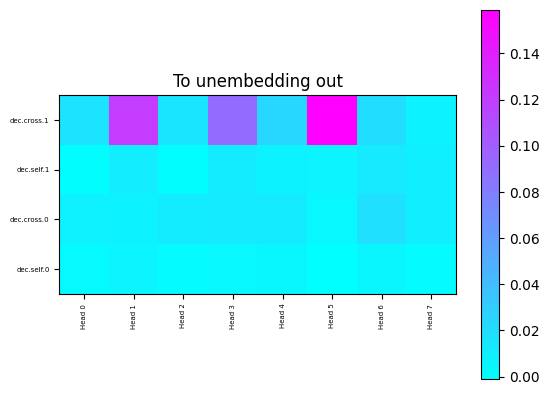

In [9]:
# %%
"""
logit attribution to the unembedding layer
"""
analyzer = backtrack.Analyzer(dataset=dataset, net=net)
analyzer.build_graph()

n_batch = len(analyzer.output['yq_predict'])
seq_q = analyzer.graph['unembedding'].input_stream.cached_activation.shape[1]
n_vocal = analyzer.net.out.weight.shape[0]

pred_tokens = []
pred_tokens_id = []
pred_arg=[0,1]
pred_arg = np.array(pred_arg)
for b in range(n_batch):
    output = np.array(analyzer.output['yq_predict'][b])
    pred_token = output[pred_arg+1]
    pred_token_id = [analyzer.langs['output'].symbol2index[t] for t in pred_token]
    pred_tokens.append(pred_token)
    pred_tokens_id.append(pred_token_id)
pred_tokens_id = np.vstack(pred_tokens_id)

token_seq = np.vstack([pred_arg.tolist() for b in range(n_batch)])


problem_stack = [analyzer.graph['unembedding'].get_problems(weight_mask=None, arg_q=token_seq, target_labels=pred_tokens_id)[0]]



current_problem = problem_stack.pop(0)
current_node = current_problem.current_node
current_problem_str = f'{current_node.module_name}.{current_node.head} {current_problem.mode}'
source_nodes = current_problem.source_stream.source_nodes

source_scores, arg_q, target_labels, target_args = current_problem.back_track(prune_names=None, metric='VAF', sequential=1)


analyzer.plot_node_scores(target_problem = current_problem, 
    source_nodes = source_nodes, 
    source_scores = source_scores, 
    cmap='cool',mid_0=False, balance=False, display=True, include_emb=False)


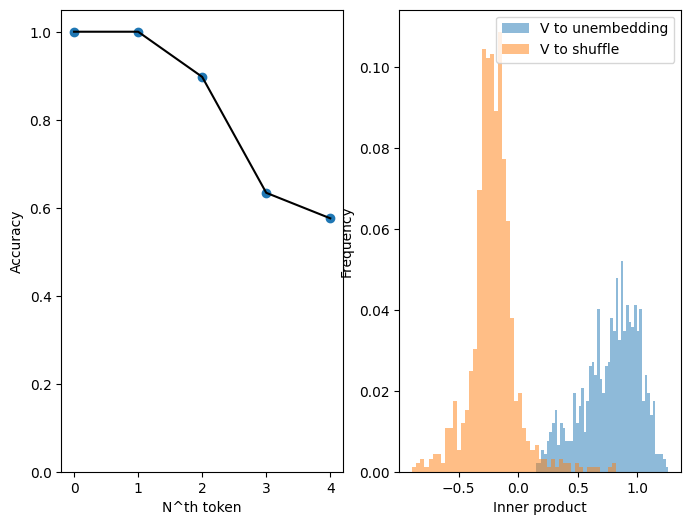

In [10]:

# %%
"""
Analyze the behavior of Dec cross layer 1, head 5
"""
block = 'dec'
layer = 1
type = 'cross'
head = 5

output = analyzer.output
n_batch = len(output['yq_predict'])
node = analyzer.graph[block, layer, type, head]

attention = node.attention_score
arg_pred = np.arange(5)
arg_max_k = attention[np.arange(n_batch),0,:len(arg_pred),:].argmax(-1)
cached_v = analyzer.graph[block, layer, type, head].v_stream.cached_activation
cached_q = analyzer.graph[block, layer, type, head].q_stream.cached_activation
cached_k = analyzer.graph[block, layer, type, head].k_stream.cached_activation


unemb_w = analyzer.net.out.weight.detach().cpu().numpy() # [n_vocab, n_dim]
unemb_node = analyzer.graph['unembedding']
prev_nodes, prev_activations = unemb_node.input_stream.forward()

for i, node in enumerate(prev_nodes):
    if node.module_name==f'{block}.{type}.{layer}' and node.head==head:
        prev_activation = prev_activations[i]
        break

if ('dec' in block) and ('cross' in type):
    type='multi'


"""
Hypothesis: 
the V symbols contain relative pos info to the nearest function
""" 
attention_percent = 0.9
acc = []
inner = []
inner_null = []


q = []
k = []
v = []
z = []

k_shuffle = []
k_shuffle_label = []

q_label=[]    
k_label=[]
v_label = []
arg_label = []
seq_label = []
z_label = []

exclude = []



for b in range(n_batch):
    xq_context = np.array(output['xq_context'][b])
    yq = output['yq'][b]
    v_acc = output['v_acc'][b]
    if v_acc==0:
        exclude.append(b)
        continue
    
    
    grammar_str = output['grammar'][b]['aux']['grammar_str']
    grammar_dict = utils.grammar_to_dict(grammar_str)

    # exclude trials with more than 1 query function
    pos_1st_sos = np.where(xq_context=='SOS')[0][0]
    query_tokens = xq_context[:pos_1st_sos]
    # keep only trials with only one function in query
    query_functions = [token for i, token in enumerate(query_tokens) if token in grammar_dict[2].keys()]
    if len(query_functions)!=1:
        exclude.append(b)
        continue

    query_func = query_functions[0]

    # find 1st colors after function
    func_poses_all = [i for i, token in enumerate(xq_context) if token==query_func]
    func_poses_single = []
    sos_poses = np.where(xq_context=='SOS')[0]

    for pos_symbol in func_poses_all:
        sos_before = sos_poses[sos_poses<pos_symbol]
        if len(sos_before)==0:
            sos_before = 0
        else:
            sos_before = sos_before[-1]
        sos_after = sos_poses[sos_poses>pos_symbol][0]
        n_func = 0
        for s in xq_context[sos_before:sos_after]: # centered around the function
            if s in grammar_dict[2].keys():
                n_func+=1
        if n_func==1:
            func_poses_single.append(pos_symbol)

    # exclude trials with no single function demonstrations
    if len(func_poses_single)<=1:
        exclude.append(b)
        continue
    
    """
    Token: Union[Symbol, Function]
    Symbol: token for color
    """

    # first predicted token
    pred_tokens = backtrack.get_top_tokens(xq_context=xq_context, attention=attention[b,0,arg_pred,:], percent=attention_percent)
    acc_b = []
    for i, token in enumerate(pred_tokens):
        if i>=len(yq):
            acc_b.append(np.nan)
            # inner.append(np.nan)
            # inner_null.append(np.nan)
            continue
        if token==yq[i]:
            acc_b.append(1)
            color_id=analyzer.langs['output'].symbol2index[yq[i]]
            color_symbol = grammar_dict[1][yq[i]]
            symbol_pos = [i for i, token in enumerate(query_tokens) if token==color_symbol][0]

            inner.append(prev_activation[b,i,:]@unemb_w[color_id,:])
            rand_id = np.random.choice(np.setdiff1d(np.arange(len(unemb_w)),color_id), 1)[0]
            inner_null.append(prev_activation[b,i,:]@unemb_w[rand_id,:])

            q.append(cached_q[b,0,i,:])
            k.append(cached_k[b,0,arg_max_k[b,i],:])
            v.append(cached_v[b,0,arg_max_k[b,i],:])
            arg_label.append(i)
            seq_label.append(symbol_pos)
        else:
            acc_b.append(0)



    # all query symbols 
    acc_b += [np.nan]*(len(arg_pred)-len(acc_b))
    acc.append(acc_b)

    query_tokens = xq_context[:pos_1st_sos]
    query_color_symbols = [token for token in query_tokens if token in grammar_dict[0].keys()]


    # color symbols not in query
    all_color_symbols = np.unique([token for token in xq_context if token in grammar_dict[0].keys()])
    color_symbols_not_in_query = np.setdiff1d(all_color_symbols, query_color_symbols)
    for color in color_symbols_not_in_query:
        all_color_pos = np.array([i for i, t in enumerate(xq_context) if t==color])
        k_shuffle.append(cached_k[b,0,all_color_pos,:])
        # symbol = grammar_dict[1][color]
        # symbol_pos = [i for i, token in enumerate(query_tokens) if token==symbol][0]
        k_shuffle_label+=[-1]*all_color_pos.shape[0]


acc = np.array(acc)
acc = np.nanmean(acc, axis=0)
inner = np.array(inner)
inner_null = np.array(inner_null)

q = np.vstack(q)
k = np.vstack(k)
v = np.vstack(v)
k_shuffle = np.vstack(k_shuffle)

# v = np.vstack(v)
# z = np.vstack(z)
v_label = np.array(v_label)
arg_label = np.array(arg_label)
seq_label = np.array(seq_label)
# z_label = np.array(z_label)
k_label = np.array(k_label)
k_shuffle_label = np.array(k_shuffle_label)
# print(k_label.mean())
# Combine datasets for joint PCA

plot_output = True
if plot_output:
    fig, ax = plt.subplots(1,2,figsize=(8,6))
    axi=ax[0]
    axi.plot(arg_pred, acc, color='k')
    axi.scatter(arg_pred, acc)
    axi.set_xticks(arg_pred)
    axi.set_ylim([0,1.05])
    axi.set_ylabel('Accuracy')
    axi.set_xlabel('N^th token')

    axi=ax[1]
    axi.hist(inner, bins=50, alpha=0.5, weights=np.ones(len(inner)) / len(inner), label='V to unembedding', )
    axi.hist(inner_null, bins=50, alpha=0.5, weights=np.ones(len(inner_null)) / len(inner_null), label='V to shuffle')
    axi.set_xlabel('Inner product')
    axi.set_ylabel('Frequency')
    axi.legend()
    plt.show()



* Setting all random seeds to  0 *
Loading model: /Users/laptopd/Documents/Compositionality/MLC-extension/src/out_models/net-HookedBIMLSmall.pt on cpu

Transformer specs:
 nparams= 930953
 nlayers_encoder= 2
 nlayers_decoder= 2
 nhead= 8
 hidden_size= 128
 dim_feedforward= 512
 act_feedforward= gelu
 dropout= 0.1
 



/Users/laptopd/Documents/Compositionality/MLC-extension/src/MI/hooked_transformer.py:298: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/laptopd/opt/anaconda3/envs/MI/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


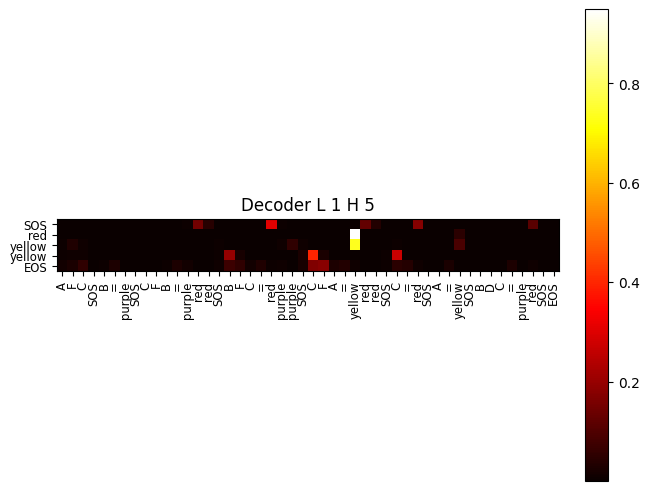

/Users/laptopd/Documents/Compositionality/MLC-extension/src/test_data/single_trial/plots/attention/dec_multi_1_5.png saved


In [11]:
# %%
"""
plot attention pattern
"""
single_trial_path = src_dir / 'test_data' / 'single_trial'
plot_dir = single_trial_path / 'plots'
_, single_trial = utils.load_net_and_dataset(model_path=model_path, 
                                            dataset_path=single_trial_path, 
                                            null_dataset_path=null_dataset_path)
head_kwargs = {'block':'dec', 'layer':1, 'type':'cross', 'head':5}
utils.plot_attention_patterns_by_head(dataset=single_trial, net=net, head_kwargs=head_kwargs, save_dir=plot_dir, rewrite=1, display=True)